In [1]:
import pandas as pd
import plotly.express as px
import utils
from umap import UMAP
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

color_discrete_map_seaborn = {
    "Targets": {
        "other targets": "#0072b2",
        "CDC25A": "#d55e00",
        "LPAR1": "#009e73",
        "PLK1": "#cc79a7",
        "AURKB": "#f0e442",
    }
}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

%matplotlib inline

UMAP of A549 plates from the primary CPJUMP1 experiment

In [2]:
batch = "2020_11_04_CPJUMP1"
cell = "A549"

experiment_df = (
    pd.read_csv("output/experiment-metadata.tsv", sep="\t")
    .query('Batch==@batch')
    .query('Cell_type==@cell')
)

In [3]:
cosine_sim = (
    pd.read_csv('output/compound_genetic_perturbation_cosine_similarity.csv', usecols=['Metadata_broad_sample', 'Metadata_matching_target','Genetic_Perturbation', 'cosine_sim'])
    .assign(Metadata_gene= lambda x: x.Metadata_matching_target)
    .query('Genetic_Perturbation=="CRISPR"')
)

metadata = (
    pd.read_csv('../metadata/external_metadata/JUMP-Target-1_compound_metadata.tsv', sep='\t', usecols=['broad_sample', 'pert_iname'])
    .rename(columns={'broad_sample': 'Metadata_broad_sample'})
)

cosine_sim = (
    cosine_sim.merge(metadata, on='Metadata_broad_sample')
    .nlargest(8, 'cosine_sim')
    .drop_duplicates(subset=['Metadata_broad_sample', 'Metadata_matching_target'])
)


Read all the plates

In [4]:
all_plates_df = pd.DataFrame()

for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query("Perturbation==@modality")
    for time_point in modality_df.Time.unique():
        time_df = modality_df.query("Time==@time_point")
        for plate in time_df.Assay_Plate_Barcode.unique():
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_batch=batch)
                .assign(Metadata_modality=modality)
                .assign(Metadata_cell=cell)
                .assign(Metadata_time=utils.time_point(modality, time_point))
            )
            if modality == "compound":
                data_df.rename(columns={'Metadata_target': 'Metadata_gene'}, inplace=True)
                data_df = data_df.merge(cosine_sim[['Metadata_broad_sample','Metadata_matching_target','cosine_sim']], on=['Metadata_broad_sample'], how='left')
            elif modality == "crispr":
                data_df = data_df.merge(cosine_sim[['Metadata_gene','Metadata_matching_target', 'cosine_sim']], on=['Metadata_gene'], how='left')
            elif modality == "orf":
                data_df["Metadata_matching_target"] = np.nan
                data_df['cosine_sim'] = 0.05
            all_plates_df = utils.concat_profiles(all_plates_df, data_df)

all_plates_df.Metadata_matching_target.fillna('other targets', inplace=True)
all_plates_df.cosine_sim.fillna(0.05, inplace=True)

all_plates_df = utils.remove_empty_wells(all_plates_df)

In [5]:
X = utils.get_featuredata(all_plates_df)

umap_2d = UMAP(n_components=2, random_state=9000)
projection_2d = umap_2d.fit_transform(X)

batch_list = list(all_plates_df.Metadata_batch)
plate_list = list(all_plates_df.Metadata_Plate)
modality_list = list(all_plates_df.Metadata_modality)
pert_list = np.where(all_plates_df.Metadata_pert_type == "control", all_plates_df.Metadata_control_type, "trt")
gene_list = list(all_plates_df.Metadata_gene)
time_list = list(all_plates_df.Metadata_time)
target_list = list(all_plates_df.Metadata_matching_target)
cosine_sim_list = list(all_plates_df.cosine_sim)

X_embedded_df = pd.DataFrame(
    {
        "Batch": batch_list,
        "Plate": plate_list,
        "Modality": modality_list,
        "Pert": pert_list,
        "Gene": gene_list,
        "Time": time_list,
        "Target": target_list,
        "Size": cosine_sim_list,
        "umap 1": projection_2d[:, :1].flatten(),
        "umap 2": projection_2d[:, 1:2].flatten(),
    }
)

X_embedded_df = X_embedded_df.sample(frac=1)

In [6]:
# to move the colored points to the top

df1 = X_embedded_df.query('Size==0.05')
df2 = X_embedded_df.query('Size!=0.05')

X_embedded_df = pd.concat([df1, df2], join='inner')

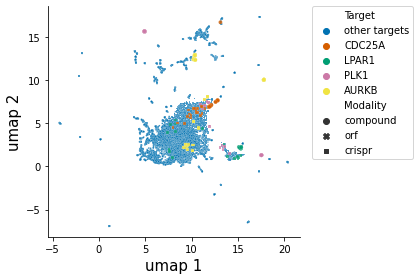

In [7]:
g = sns.scatterplot(
    data=X_embedded_df,
    x="umap 1",
    y="umap 2",
    hue=X_embedded_df["Target"],
    style=X_embedded_df["Modality"],
    size=X_embedded_df["Size"],
    sizes=[3,15,15,15,15,15],
    alpha=0.8,
    hue_order=['other targets', 'CDC25A', 'LPAR1', 'PLK1', 'AURKB'],
    palette=color_discrete_map_seaborn["Targets"]
)

h,k = g.get_legend_handles_labels()
del k[6:13] # remove size label
del h[6:13] # remove size label
plt.legend(h,k,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
g.axes.set_xlabel(g.axes.get_xlabel(), fontsize=15)
g.axes.set_ylabel(g.axes.get_ylabel(), fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(f'figures/9.A549_UMAP.png')
